# Edmonton Housing Price Prediction

## Load in Data

In [110]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import norm

In [111]:
# import housing data
raw_train = pd.read_csv('../Data/EdmontonRealEstateData_train.csv')

In [112]:
# drop columns with uninteresting parameters
train = raw_train.drop(['house_suit','house_number','house_suff','street_name', 'city', 'full_address', 'fully_taxable',\
                      'display_type', 'geometry', 'result_code', 'build_year_mbc'], axis=1)

In [113]:
# rows and columns of data
train.shape

(42779, 22)

In [114]:
# types of columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42779 entries, 0 to 42778
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  42779 non-null  int64  
 1   taxroll_number              42779 non-null  int64  
 2   landuse_description         42779 non-null  object 
 3   market_building_class       40471 non-null  object 
 4   effective_build_year        40455 non-null  float64
 5   net_area                    42779 non-null  float64
 6   basement_finished           42779 non-null  object 
 7   has_garage                  42779 non-null  object 
 8   has_fireplace               42779 non-null  object 
 9   assessed_value              42779 non-null  int64  
 10  postal_code                 40287 non-null  object 
 11  neighbourhood               42779 non-null  object 
 12  fully_complete              40475 non-null  object 
 13  lot_size                    427

## Data pre-processing

In [115]:
# find how many null values each column has
train.isna().sum().sort_values(ascending=False)

postal_code                   2492
effective_build_year          2324
site_coverage                 2323
market_building_class         2308
fully_complete                2304
assessed_value                   0
taxroll_number                   0
landuse_description              0
net_area                         0
basement_finished                0
has_garage                       0
has_fireplace                    0
lat                              0
lon                              0
neighbourhood                    0
lot_size                         0
building_count                   0
walkout_basement                 0
air_conditioning                 0
valuation_group                  0
tot_gross_area_description       0
Unnamed: 0                       0
dtype: int64

Blank values for postal code -> Not sure, but not critical to the model development

Blank values for effective build year -> Mostly Undeveloped land

Blank values for site coverage -> Mostly Undeveloped land

Blank values for market building class -> Mostly Undeveloped land

Blank values for build year mbc -> Mostly Undeveloped land

Blank Values for fully complete -> Mostly Undeveloped land

Intuitively speaking, most of these columns don't play a big factor in the house price except perhaps the build year.

In [116]:
# drop all nulls except effective_build_year and build_year_mbc
train = train.drop(["postal_code", "site_coverage", "market_building_class", "fully_complete", "effective_build_year", "neighbourhood"], axis=1)

In [117]:
train.isna().sum().sort_values(ascending=False)

lat                           0
lon                           0
tot_gross_area_description    0
valuation_group               0
air_conditioning              0
walkout_basement              0
building_count                0
lot_size                      0
assessed_value                0
has_fireplace                 0
has_garage                    0
basement_finished             0
net_area                      0
landuse_description           0
taxroll_number                0
Unnamed: 0                    0
dtype: int64

Build year mbc is the year the property was built along with its market building class. I'll replace the blank values with None since undeveloped land does not have a build year. Imputing values doesn't make sense here.

Pandas already makes the blank values equal to None.

In [118]:
# just keep m^2 value for tot_gross_area_description
train['tot_gross_area_description'] = train['tot_gross_area_description'].astype(str)
train['tot_gross_area_description'] = train['tot_gross_area_description'].str.split(' ',1,expand=True)
train['tot_gross_area_description'] = train['tot_gross_area_description'].astype('float')
train['tot_gross_area_description']

0        227.50
1        215.60
2        217.10
3        226.00
4        238.90
          ...  
42774    140.50
42775    269.76
42776    397.50
42777    332.00
42778    293.90
Name: tot_gross_area_description, Length: 42779, dtype: float64

In [119]:
# just keep m^2 value lot_size
train['lot_size'] = train['lot_size'].astype(str)
train['lot_size'] = train['lot_size'].str.split(' ',1,expand=True)
train['lot_size'] = train['lot_size'].astype('float')
train['lot_size']

0          482.279
1          396.875
2          403.359
3          375.192
4          399.361
           ...    
42774      300.086
42775    11602.978
42776    10159.394
42777    12952.555
42778     7937.551
Name: lot_size, Length: 42779, dtype: float64

In [120]:
# encode some categorical variables
train['basement_finished'] = train['basement_finished'].map({'Yes': 1, 'NO': 0})
train['has_garage'] = train['has_garage'].map({'Yes': 1, 'NO': 0})
train['has_fireplace'] = train['has_fireplace'].map({'Yes': 1, 'NO': 0})
train['walkout_basement'] = train['walkout_basement'].map({'Yes': 1, 'NO': 0})
train['air_conditioning'] = train['air_conditioning'].map({'Yes': 1, 'NO': 0})

In [121]:
# dumb down landuse_description into a more usable format
# 0 - single residential
# 1 - multi residential
# 2 - commercial
# 4 - industrial
# 5 - religious
# 6 - undeveloped
# 7 - blended
train['landuse_description'] = train['landuse_description'].map({'100% SINGLE FAMILY DWELLING': 0, '100% SEM-DETACHED DWELLING (DUPLEX)': 1, 
                                                                '100% ONE FAMILY DWELLING WITH SUITE': 0, '100% DUPLEX - SIDE BY SIDE': 1, '100% UNDEVELOPED RESIDENTIAL LAND': 6 ,
                                                                '100% ONE DWELLING UNIT ACCESSORY BLDG': 0, '100% SEMI DETACHED DWLG WITH SUITE (DUPLEX)': 1, '100% SEMI-DETACHED DWELLING (FOUR-PLEX OR MORE)': 1,
                                                                '100% SEMI-DETACHED DWELLING (TRI-PLEX)': 1, '100% DUPLEX SIDE BY SIDE LOWER LEVEL UNITS': 1, '100% CO-OP/NON-PRO HOUSING DETACHUNIT': 1,
                                                                '100% HOUSE 3 OR LESS RENTAL SELF-CONTAINED UNITS': 1, '100% THREE/FOUR FAMILY DWELLING-OTHER': 1, '100% HOUSE 4 OR MORE RENTAL SELF-CONTAINED UNITS': 1,
                                                                '100% OTHER TWO FAMILY DWELLING': 1, '100% PARKING LOT - UNPAVED NO NETS': 2, '100% TRI-PLEX': 1, '100% DERELICT RESIDENTIAL': 0, '100% DUPLEX - UP AND DOWN': 1,
                                                                '100% DUPLEX UP AND DOWN LOWER LEVEL UNITS': 1, '100% CONVENT/SEMINARY': 5, '100% RELIGIOUS - WORSHIP': 5, '100% 2 OR MORE FAMILY UNITS ON 1 PCL': 1,
                                                                '100% HANDICAPPED HOME': 0, '100% RELIGIOUS - OTHER': 5, '50% COMM BUSINESS/SERVICE - OTHER|50% SINGLE FAMILY DWELLING': 7, '55% SINGLE FAMILY DWELLING|45% COMM BUSINESS/SERVICE - OTHER': 7,
                                                                '71% SINGLE FAMILY DWELLING|29% COMM BUSINESS/SERVICE - OTHER': 7, '80% SINGLE FAMILY DWELLING|20% NONFRMLD W OTHER BLDGS': 7, '67% SINGLE FAMILY DWELLING|33% NONFRMLD W OTHER BLDGS': 7,
                                                                '95% SINGLE FAMILY DWELLING|5% WAREHOUSE/STORAGE FACILITY-OTHER': 7, '94% SINGLE FAMILY DWELLING|6% COMM BUSINESS/SERVICE - OTHER': 7, '100% DUPLEX BACK TO BACK LOWER LEVEL UNITS': 1, '100% BARE LAND CONDO (RESIDENTIAL)': 0})


In [122]:
# categorize valuation group
train['valuation_group'] = train['valuation_group'].map({
    'RESIDENTIAL SOUTH': 0,
    'RESIDENTIAL NORTH': 1,
    'RESIDENTIAL WC': 2,
    'RESIDENTIAL RIVVAL': 3,
    'RESIDENTIAL LAND': 4,
    'SPECIAL PURPOSE': 5,
    'LAND': 6
})

In [123]:
# get rid of unnamed column
train = train.iloc[:,1:]

## Exploring Data

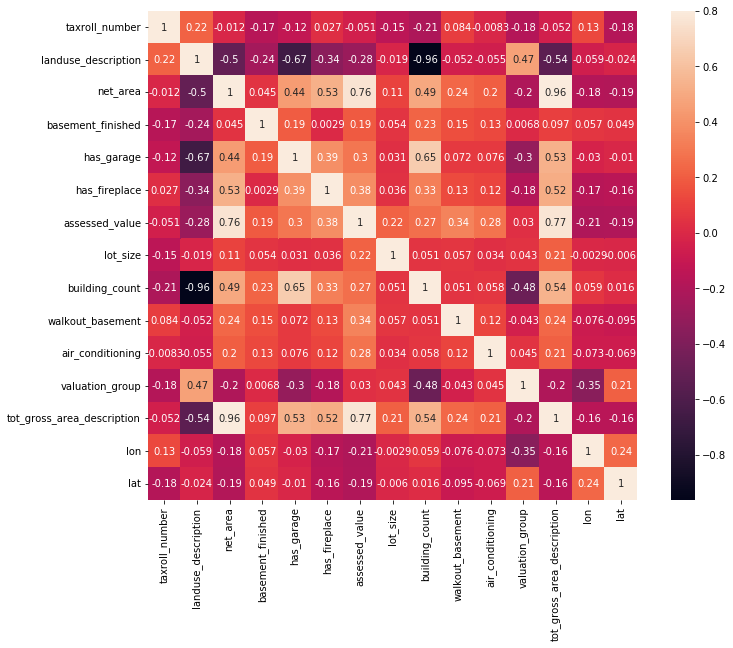

In [124]:
# correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,annot=True, vmax=0.8, square=True)

In [125]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42779 entries, 0 to 42778
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   taxroll_number              42779 non-null  int64  
 1   landuse_description         42779 non-null  int64  
 2   net_area                    42779 non-null  float64
 3   basement_finished           42779 non-null  int64  
 4   has_garage                  42779 non-null  int64  
 5   has_fireplace               42779 non-null  int64  
 6   assessed_value              42779 non-null  int64  
 7   lot_size                    42779 non-null  float64
 8   building_count              42779 non-null  int64  
 9   walkout_basement            42779 non-null  int64  
 10  air_conditioning            42779 non-null  int64  
 11  valuation_group             42779 non-null  int64  
 12  tot_gross_area_description  42779 non-null  float64
 13  lon                         427

In [126]:
train['assessed_value'].describe()

count    4.277900e+04
mean     4.770349e+05
std      2.583694e+05
min      4.150000e+04
25%      3.485000e+05
50%      4.225000e+05
75%      5.365000e+05
max      8.447500e+06
Name: assessed_value, dtype: float64

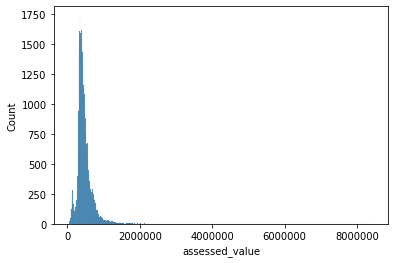

In [127]:
sns.histplot(train['assessed_value'])

In [128]:
# data is right-skewed,should be normally distributed
train['assessed_value'] = np.log(train['assessed_value'])

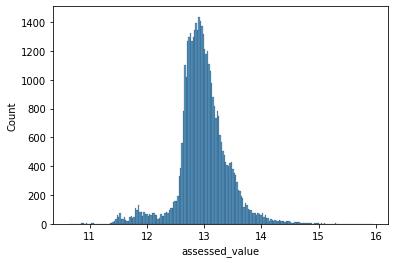

<Figure size 432x288 with 0 Axes>

In [129]:
# plot data
sns.histplot(train['assessed_value'])
fig = plt.figure()

net_area and tot_gross_area_description data are also right-skewed, but applying log and sqrt transformations just makes it left skewed

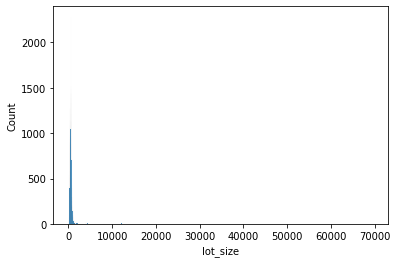

<Figure size 432x288 with 0 Axes>

In [130]:
# as seen below, lot_size is also right-skewed
sns.histplot(train['lot_size'])
fig = plt.figure()

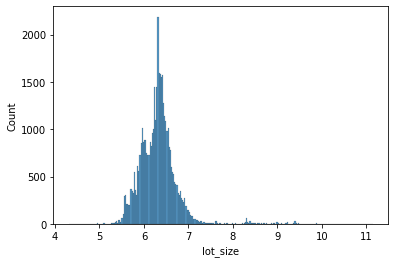

<Figure size 432x288 with 0 Axes>

In [131]:
# transform lot_size data
train['lot_size'] = np.log(train['lot_size'])
# plot data
sns.histplot(train['lot_size'])
fig = plt.figure()

## Fit a LASSO model

In [136]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

In [137]:
X = train.loc[:,['landuse_description', 'net_area', 'basement_finished', 'has_garage', 'has_fireplace', 'lot_size', 'building_count', 'walkout_basement', 'air_conditioning', 'valuation_group', 'tot_gross_area_description', 'lon', 'lat']]
Y = train['assessed_value']
X_train, X_test, Y_train, Y_test = train_test_split( X , Y , test_size = 0.1, random_state = 5)
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_train, Y_train)
lasso_predict = lasso.predict(X_test)
lasso_error = mean_squared_error(Y_test, lasso_predict)
lasso_r2 = r2_score(Y_test, lasso_predict)

In [146]:
lasso_r2

0.7436851313354218

In [144]:
# print out coefficients
lasso.coef_

for coef in lasso.coef_:
    print(coef)

-0.0
0.0013240076814128297
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0030690546143752225
-0.0
-0.0


In [152]:
lasso_error

0.04885707154221564

## Fit a Ridge Regression model

In [147]:
ridge = linear_model.Ridge(alpha=1.0)
ridge.fit(X_train, Y_train)
ridge.pred = ridge.predict(X_test)
ridge.err = mean_squared_error(Y_test, ridge.pred)
ridge.r2 = r2_score(Y_test, ridge.pred)

In [149]:
ridge.r2

0.8310392573062456

In [150]:
# print out coefficients
for coef in ridge.coef_:
    print(coef)

-0.07670759053206945
0.0028287731124685433
0.06049016545611018
0.07639521594091739
0.08598507741870866
0.1869094804225307
-0.06984782641972426
0.20833267851299297
0.10367643670965342
0.037126138940834066
0.000367801804089033
-0.11029467159061664
-0.6894722534439285


In [151]:
ridge.err

0.03220619676347105

## Fit a Multi-Linear Regression Model

In [155]:
from sklearn.linear_model import LinearRegression
lin_fit = LinearRegression().fit(X, Y)
lin_pred = lin_fit.predict(X_test)
lin_err = mean_squared_error(Y_test, lin_pred)
lin_r2 = r2_score(Y_test, lin_pred)

In [156]:
lin_r2

0.8315118808032336

In [157]:
lin_err

0.032116108349462213

## Fit a Random Forest Regression Model

In [159]:
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor(n_estimators=500)
RFR.fit(X_train, Y_train)
RFR_pred = RFR.predict(X_test)
RFR_err = mean_squared_error(Y_test, RFR_pred)
RFR_r2 = r2_score(Y_test, RFR_pred)

In [160]:
RFR_r2

0.9427304610556737

In [161]:
RFR_err

0.010916346663658568

## Fit XGBoost Model

In [162]:
from xgboost import XGBRegressor

In [168]:
xgb = XGBRegressor(n_estimators=500)
xgb.fit(X_train, Y_train, verbose=False)
xgb_pred = xgb.predict(X_test)
xgb_err = mean_squared_error(Y_test, xgb_pred)
xgb_r2 = r2_score(Y_test, xgb_pred)

In [169]:
xgb_r2

0.9488583008664491

In [170]:
xgb_err

0.009748297733863263

## Predict on Test Set